In [14]:
from snp.SNP500 import SNP500
from tqdm.auto import tqdm

import pandas as pd

In [19]:
snp = SNP500()
tickers = snp.get_tickers()

In [36]:
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
from datetime import date

news_url = "https://finviz.com/quote.ashx?t="

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36"
}

data = pd.DataFrame(columns=["Date", "Headline", "Ticker"])
tickers = ["AGG", "DBC", "SPY"]

row_index = 0
for ticker in tqdm(tickers[:25]):
    ticker_url = f"{news_url}{ticker}"
    req = Request(url=ticker_url, headers=headers)
    response = urlopen(req)
    html = BeautifulSoup(response, "html.parser")
    news_table = html.find(id="news-table")
    
    for row in news_table.findAll("tr"):
        try:
            title = row.a.text
            date_text = row.td.text.split()
            
            if date_text[0] == "Today":
                date_str = str(date.today())
            else:
                date_str = date_text[0]
            
            data.loc[row_index, ["Date", "Headline", "Ticker"]] = [date_str, title, ticker]
            row_index += 1
            
        except AttributeError as e:
            continue

# Convert the 'Date' column to pandas date type
data['Date'] = pd.to_datetime(data['Date']).dt.date


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


In [39]:
data[data.Ticker == 'SPY'].sort_values(by="Date")

,Date,Headline,Ticker
298,2023-08-01,"Oil, commodities, small-caps in focus amid inf...",SPY
297,2023-08-02,An Irrefutable Bull Market Is in Sight. Here's...,SPY
295,2023-08-03,Can Investing in Commodities Boost Your Return...,SPY
294,2023-08-08,Yahoo Finance Chartbook: 50 charts tell the st...,SPY
293,2023-08-09,The New ETF That Offers 100% Downside Protection,SPY
...,...,...,...
233,2023-09-14,S&P500 Logs Worst Month Since February: 5 Top ...,SPY
231,2023-09-14,Stocks open lower as worries about inflation r...,SPY
230,2023-09-14,US futures slip as worries about inflation rev...,SPY
255,2023-09-14,"August jobs report: US economy adds 187,000 jo...",SPY


In [41]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Function to apply VADER analysis
def analyze_sentiment(headline):
    return analyzer.polarity_scores(headline)['compound']

# Filter SPY ticker data
spy_data = data[data.Ticker == 'SPY'].sort_values(by="Date")

# Apply VADER analysis
spy_data['Sentiment'] = spy_data['Headline'].apply(analyze_sentiment)


<Axes: xlabel='Date'>

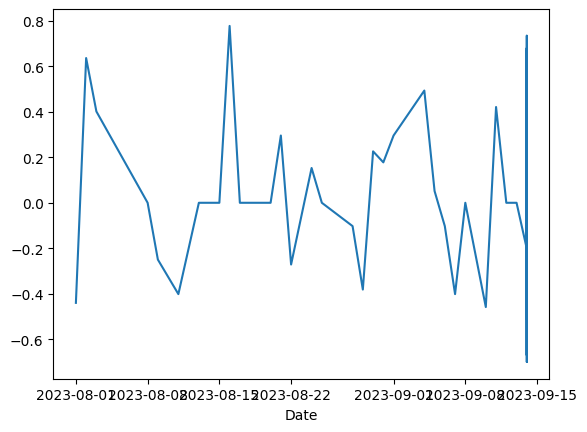

In [57]:
spy_data.sort_values(by='Date').set_index('Date').Sentiment.plot()